TODO
1. Take streaming_history, note all the songs, find clusters of songs played together (weight by listening time), output clusters of a certain size
2. Use spotify API to turn clusters into playlists in the app

In [ ]:
streaming_history_json = 'Spotify Account Data/StreamingHistory.json'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spotipy
from tqdm import tqdm
import sklearn as skl

In [2]:
data = pd.read_json(streaming_history_json)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29996 entries, 0 to 29995
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     29996 non-null  object
 1   artistName  29996 non-null  object
 2   trackName   29996 non-null  object
 3   msPlayed    29996 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 937.5+ KB


In [12]:
# convert endTime to datetime
data['endTime2'] = pd.to_datetime(data['endTime'])

In [13]:
data

,endTime,artistName,trackName,msPlayed,endTime2
0,2022-12-02 09:13,Rustage,Fire,137811,2022-12-02 09:13:00
1,2022-12-02 09:28,ZAQ,カーストルーム,990,2022-12-02 09:28:00
2,2022-12-02 09:31,Rustage,Win Streak,160714,2022-12-02 09:31:00
3,2022-12-02 09:35,Rustage,Gol D Roger,175285,2022-12-02 09:35:00
4,2022-12-02 09:39,Rustage,Team Avatar,240000,2022-12-02 09:39:00
...,...,...,...,...,...
29991,2023-12-02 23:43,Daddyphatsnaps,Easy Bag,225230,2023-12-02 23:43:00
29992,2023-12-02 23:46,Pokémon,Pokémon Johto,174920,2023-12-02 23:46:00
29993,2023-12-02 23:52,MemLovate,Bopping to Bede's Theme,1600,2023-12-02 23:52:00
29994,2023-12-02 23:52,None Like Joshua,Pokémon GO Rap! (from Pokémon Red and Pokémon GO),3854,2023-12-02 23:52:00


In [14]:
# get unique track names
track_list = data['trackName'].unique()
len(track_list)

1654

1. Define a correlation matrix of track_list vs track_list
2. For every song, find which songs are likely to come after it
3. Bias this by whether the song was actually listened to, whether it was in the same listening session (check endtime), how many songs away is it, and also bias towards my recent listening history more than my past listening history.
4. 

In [21]:
data['minPlayed'] = data['msPlayed'] / 60000

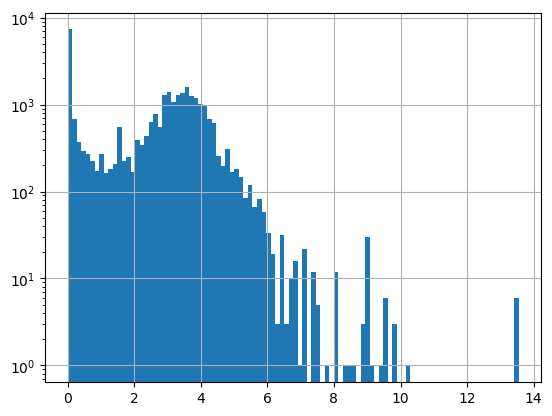

In [22]:
data['minPlayed'].hist(bins=100)
# plt.ylim(0,2000)
plt.yscale('log')

In [23]:
# filter data by removing all tracks played for less than 10000 ms
data_filtered= data[data['msPlayed'] > 10000]

In [42]:
# initialize correlation matrix with zeros
corr_matrix  = pd.DataFrame(index=track_list, columns=track_list)
corr_matrix = corr_matrix.fillna(0)
corr_matrix

,Fire,カーストルーム,Win Streak,Gol D Roger,Team Avatar,クライマー,CRAZY NOISY BIZARRE TOWN,いじめっ子Bully,fake ass gold,Yona Yona Journey,...,Sausage Rap,Poker Face (Eric Cartman),Andrew Tate the Top G,Subway Sexists,Richest Killers,Beautiful Mind,Sunflower - Spider-Man: Into the Spider-Verse,What's Up Danger (with Black Caviar),Biri-Biri,It's Going Down
Fire,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
カーストルーム,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Win Streak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gol D Roger,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Team Avatar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Beautiful Mind,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sunflower - Spider-Man: Into the Spider-Verse,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
What's Up Danger (with Black Caviar),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Biri-Biri,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
nametag = 'GP'

# parameters
lookahead_time = 60 # minutes
nametag += f'_lt_{lookahead_time}'

recency_scale = 0.1 # minimum score for recency, controls importance of recency vs nearness
recency_bias = 5 # times the weight to the choices of last year
nearness_scale = 5 # maximum score for nearness, controls importance of recency vs nearness

nearness_function = "GP" # "GP" or "Gompertz", Gompertz gives more weight to the next 5-6 songs and much less to the rest
nearness_factor_gp = 0.95 # how much the score decreases with distance

# parameters for Gompertz function
nearness_factor_beta = 5 
nearness_factor_alpha = 1
nearness_factor_gamma = (0.18-0.1123)*(lookahead_time-601)/(60-601)+0.1123 # 0.18 for 1 hour, 0.1123 for 10 hours, linear interpolation in between

last_song_datetime = data_filtered['endTime2'].max()
first_song_datetime = data_filtered['endTime2'].min()

In [84]:
def recency_score(listen_datetime):
    # linear interpolation between last_song_datetime and first_song_datetime with recency_bias
    pure_score = (listen_datetime - first_song_datetime) / (last_song_datetime - first_song_datetime) * (recency_bias - 1) + 1
    scaled_score = pure_score * recency_scale
    return scaled_score

In [85]:
def nearness_score(distance, function = "GP"):
    if function == "GP":
        return nearness_scale * nearness_factor_gp ** distance
    elif function == "Gompertz":
        return nearness_scale*(1-nearness_factor_alpha*np.exp(-nearness_factor_beta*np.exp(nearness_factor_gamma*distance)))

In [97]:
history_index = data_filtered.index
for i in tqdm(range(len(history_index))):
    index = history_index[i]
    track = data_filtered.loc[index]
    song = track['trackName']

    # get all songs played within 60 minutes of the current song
    time = track['endTime2']
    time_end = time + pd.Timedelta(minutes=lookahead_time)
    related_songs = data_filtered[(data_filtered['endTime2'] > time) & (data_filtered['endTime2'] < time_end)]

    for distance in range(len(related_songs)):
        related_song = related_songs.iloc[distance]
        related_song_name = related_song['trackName']
        related_song_endtime = related_song['endTime2']

        # calculate score
        recency = recency_score(related_song_endtime)
        nearness = nearness_score(distance, function = nearness_function)
        score = recency * nearness

        # add score to correlation matrix
        corr_matrix.loc[song, related_song_name] += score

100%|██████████| 22470/22470 [01:55<00:00, 194.54it/s]


In [87]:
corr_matrix

,Fire,カーストルーム,Win Streak,Gol D Roger,Team Avatar,クライマー,CRAZY NOISY BIZARRE TOWN,いじめっ子Bully,fake ass gold,Yona Yona Journey,...,Sausage Rap,Poker Face (Eric Cartman),Andrew Tate the Top G,Subway Sexists,Richest Killers,Beautiful Mind,Sunflower - Spider-Man: Into the Spider-Verse,What's Up Danger (with Black Caviar),Biri-Biri,It's Going Down
Fire,0.0,0.000000,2.000274,1.975541,1.805357,1.715128,1.629520,1.548103,1.470765,1.861307,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0
カーストルーム,0.0,0.000000,0.307214,0.151560,0.000000,0.000000,0.000000,0.159533,1.911034,2.335459,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0
Win Streak,0.0,0.400223,2.959398,3.729361,3.081799,5.168155,3.612058,1.964626,3.405305,7.352217,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0
Gol D Roger,0.0,0.941832,0.000000,0.000000,2.610817,1.900419,5.309684,2.385493,2.148247,2.595831,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0
Team Avatar,0.0,0.000000,0.159937,2.247034,0.000000,2.591208,1.947322,1.805631,3.773235,2.395607,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Beautiful Mind,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0
Sunflower - Spider-Man: Into the Spider-Verse,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0.0,0.0,0,0,0.0,0.725701,0.434566,0
What's Up Danger (with Black Caviar),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.491586,0.000000,0.000000,0.000000,...,0,0,0.0,0.0,0,0,0.0,0.562770,1.566629,0
Biri-Biri,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0.0,0.0,0,0,0.0,0.000000,0.000000,0


In [88]:
# how many non-zero entries are there?
num_non_zero= corr_matrix[corr_matrix > 0].count().sum()
total = 1654**2
print(f"Non-zero entries: {num_non_zero} / {total} = {num_non_zero/total*100:.2f}%")

Non-zero entries: 439755 / 2735716 = 16.07%


In [89]:
# Less f ing gooooo
corr_matrix.to_csv(f'Results/corr_matrix_{nametag}.csv')

In [90]:
# flatten correlation matrix
corr_matrix_flat = corr_matrix.stack().reset_index()
corr_entries = corr_matrix_flat[0]
# drop all zero entries
corr_entries = corr_entries[corr_entries > 0]

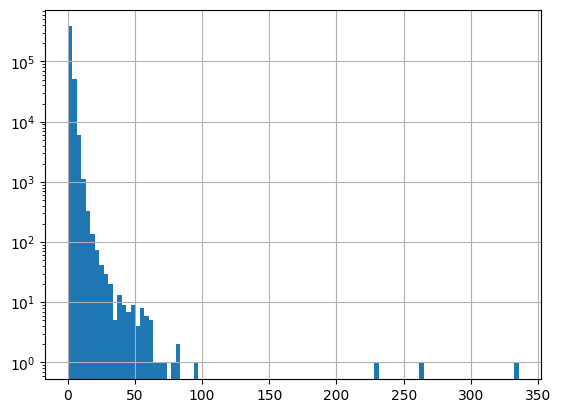

In [91]:
corr_entries.hist(bins=100)
plt.yscale('log')

In [92]:
# rename the columns of corr_matrix_flat to "initial song", "related song", "score"
corr_matrix_flat.columns = ['initial song', 'related song', 'score']

In [93]:
# jason will now investigate this bs
# lazy dumbass left me to do it
corr_matrix_flat.sort_values('score', ascending=False).head(20)

,initial song,related song,score
1754300,Devil's Luck,Devil's Luck,335.428555
1828775,This Feeling,This Feeling,264.585881
2148190,Counting Stars,Counting Stars,228.288932
2399750,History Of Man,History Of Man,96.404935
1832086,Halley's Comet,Hold Me Down,82.865739
1832085,Halley's Comet,Halley's Comet,80.855268
1876770,City Of Stars,City Of Stars,78.167537
2692685,Oh wow!,Oh wow!,73.131092
1832087,Halley's Comet,My Moment,69.536708
1838701,Static,Halley's Comet,63.897635


In [94]:
# playlist generation function
def generate_playlist(first_song,num=100):
    playlist = [first_song]
    recommended_songs = corr_matrix.loc[first_song].sort_values(ascending=False)
    # print(recommended_songs)
    playlist.extend(recommended_songs.index[:num-1])
    return playlist

In [95]:
generate_playlist('Win Streak')

['Win Streak',
 'UK BIAS',
 'Bakugo Rap',
 'Thought Crime',
 "Virtue's Last Reward",
 "Can't Stop",
 'Yona Yona Journey',
 'Fleeting Lullaby',
 'ハイヤーグラウンド',
 'Scuffed Up Age',
 'Wanted, Wasted',
 'Outside the Airlock',
 'Sage Mode (Jiraiya Rap)',
 'Wado Ichimonji',
 'Soundless',
 'Trust my Sound',
 'Bleed (My Hero Academia)',
 '生命線',
 'チキチキバンバン',
 'Stupid',
 "Captain's Quarters",
 'Legend',
 'Make my story',
 'Fairy Tale Guild Rap Cypher - Remix',
 'The Evil King',
 'Backlight',
 'Born For This',
 'クライマー',
 'Deku Rap (Full Cowl) - Remastered',
 'Bakugo (My Hero Academia Rap)',
 'Overhaul Rap',
 'スターマーカー (Album Mix)',
 'Shakedown',
 'Legends Are Made',
 'Oh wow!',
 'Deal with',
 '綺羅キラー',
 'Belle Mere',
 'FOOLS',
 'Burn It Down (My Hero Academia)',
 'ラブ・ドラマティック (Funky Flag Version)',
 'ないない',
 'Make ’Em Afraid',
 'SOUVENIR',
 'Wealth Fame Power',
 'Pokémon Theme',
 'Showdown',
 '厨病激発ボーイ',
 'Kirishima Rap (Red Riot)',
 'Plus Ultra',
 'Wizard',
 'ギリギリRide it out',
 'DEJA VU',
 'Blue Haired